In [7]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
import matplotlib.pyplot as plt
import numpy as np

In [8]:
tweet = pd.read_csv("tweetvolumebitcoin.csv", error_bad_lines=False,engine = 'python')

In [9]:
#CLEANING DATA

from datetime import datetime
for row in range(len(tweet['Date'])):
    temp = tweet.iloc[row,0]
    tweet.loc[row,['Date']]= datetime.strftime(datetime.strptime(temp,'%m-%d-%Y').date(),'%d-%m-%Y')
tweet.head()

,Date,bitcoin,btc,cryptocurrency
0,07-04-2014,"23,297","4,848",0
1,08-04-2014,"24,112","5,171",0
2,09-04-2014,"26,953","5,412",0
3,10-04-2014,"25,589","5,510",0
4,11-04-2014,"22,617","5,256",0


In [10]:
#CONVERTING TO THE RIGHT DATE TIME FORMAT
btc=pd.read_csv('btc-usd-max.csv',error_bad_lines=False,engine = 'python')
for row in range(len(btc['snapped_at'])):
    temp = btc.iloc[row,0]
    btc.loc[row,['snapped_at']]= datetime.strptime(temp[:10],'%d-%m-%Y').date()
    

In [11]:
tweet['Date'] =  pd.to_datetime(tweet['Date'])
btc['snapped_at'] = pd.to_datetime(btc['snapped_at'])

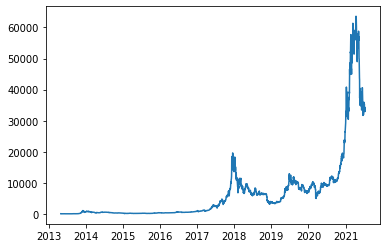

In [12]:
plt.plot(btc['snapped_at'], btc['price'])
plt.show()

In [13]:
#Creating a lag of one day and calculating returns and change in price
btc = btc.assign(Returns=btc['price'] - (btc['price'].shift(1) - 1) )
btc = btc.assign(Change=btc['price']/btc['price'].shift(1) - 1)
btc = btc.assign(Price=btc['price'].shift(1))
btc.head()

,snapped_at,price,market_cap,total_volume,Returns,Change,Price
0,2013-04-28,135.30,1.500518e+09,0.0,NaN,NaN,NaN
1,2013-04-29,141.96,1.575032e+09,0.0,7.66,0.049224,135.30
2,2013-04-30,135.30,1.501657e+09,0.0,-5.66,-0.046915,141.96
3,2013-05-01,117.00,1.298952e+09,0.0,-17.30,-0.135255,135.30
4,2013-05-02,103.43,1.148668e+09,0.0,-12.57,-0.115983,117.00


In [14]:
btc = btc.assign(Volume=btc['total_volume'].shift(1))

In [15]:
#DROPPING IRRELEVANT FEATURES
btc = btc.drop(['market_cap', 'price', 'total_volume'], axis = 1)

In [16]:
btc = btc.rename(columns={"snapped_at":"Date"})

In [17]:
#CONCATENATING TABLE FOR TWEET VOLUMESS AND BITCOIN PRICE WITH DATE INDEX
btctweet = pd.concat([btc.set_index('Date'), tweet.set_index('Date') ], axis=1)
btctweet.head()

,Returns,Change,Price,Volume,bitcoin,btc,cryptocurrency
Date,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,7.66,0.049224,135.30,0.0,NaN,NaN,NaN
2013-04-30,-5.66,-0.046915,141.96,0.0,NaN,NaN,NaN
2013-05-01,-17.30,-0.135255,135.30,0.0,NaN,NaN,NaN
2013-05-02,-12.57,-0.115983,117.00,0.0,NaN,NaN,NaN


In [18]:
#DROP ALL NULL DATA CELLS
btctweet.dropna(inplace = True)
btctweet.head()

,Returns,Change,Price,Volume,bitcoin,btc,cryptocurrency
Date,,,,,,,
2014-01-05,71.27,0.082754,849.14,36344700.0,"20,434","5,146",0
2014-01-06,17.97,0.018457,919.41,62414600.0,"16,024","5,447",0
2014-01-07,-108.88,-0.117346,936.38,88584600.0,"27,626","5,449",0
2014-01-08,12.82,0.014301,826.50,80268100.0,"26,925","5,185",0
2014-01-09,15.97,0.017857,838.32,78060300.0,"25,108","5,314",0


In [19]:
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

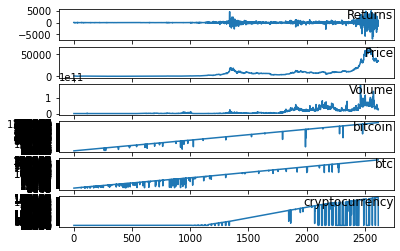

In [21]:
#creating a plot for comparison of colleration
btctweet.replace(',','', regex=True, inplace=True)
values = btctweet.values
groups = [0,2,3,4,5, 6]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(btctweet.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [22]:
#TESTING WHICH FEATURE CORRELATES BEST [WHICH KEYWORD] -> btc better than bitcoin
btctweet['bitcoin'] = pd.to_numeric(btctweet['bitcoin']) 
btctweet['Price'].corr(btctweet['bitcoin'])

0.7123962226223451

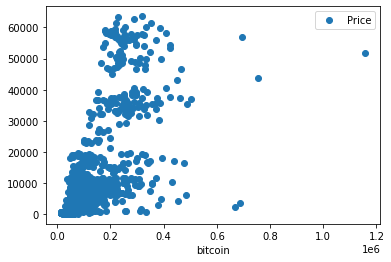

In [23]:
btctweet.plot(x="bitcoin", y="Price", style="o") 

In [25]:
btctweet['btc'] = pd.to_numeric(btctweet['btc']) 
btctweet['Price'].corr(btctweet['btc'])

0.8647962901568979

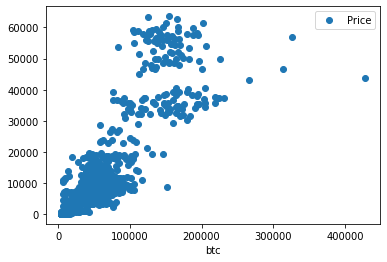

In [27]:
btctweet.plot(x="btc", y="Price", style="o") 

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
#CONVERTING TO A SERIES 
series = pd.DataFrame(data=btctweet['Price'].values, index=pd.to_datetime(btctweet.index), columns = ['Price']).dropna()


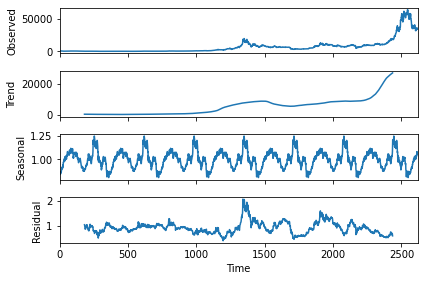

In [30]:
# SEASONALITY AND TRENDS CHECK IN BITCOIN
result = seasonal_decompose(series.values, model='multiplicative', freq=365)
result.plot()
plt.show()

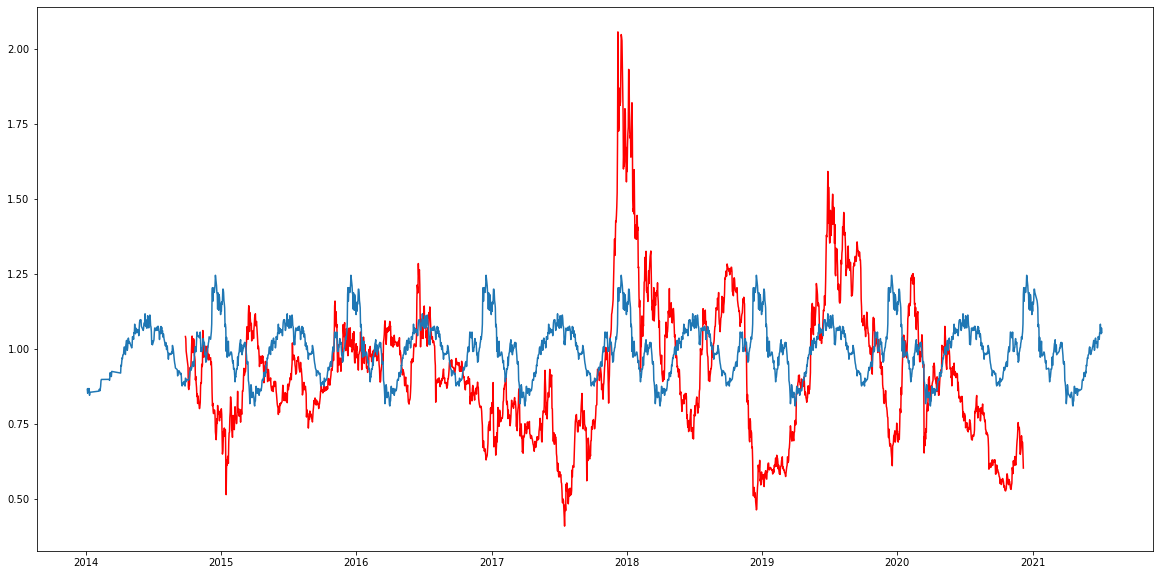

In [31]:
#checking seasonality vs. noise
plt.figure(figsize=(20,10))
plt.plot(series.index, result.resid, color='r')
plt.plot(series.index, (result.seasonal))


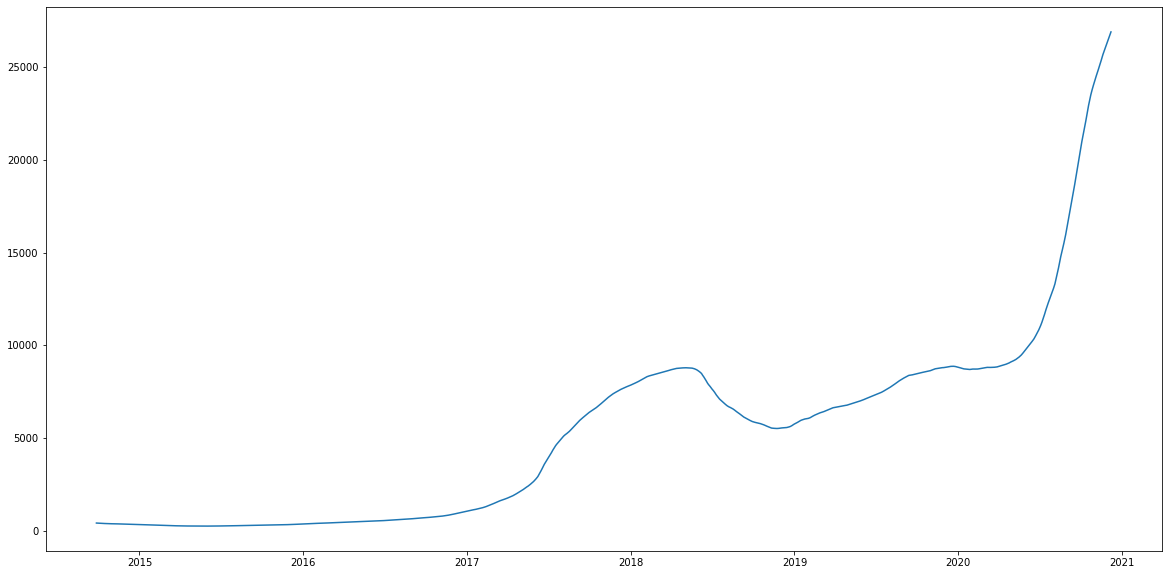

In [32]:
#Trend curve of bitcoin price
plt.figure(figsize=(20,10))
plt.plot(series.index, result.trend)

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [34]:
values = btctweet.values
cols = btctweet.columns.tolist()
cols = cols[-1:] + cols[:-1]
btctweet = btctweet[cols]
btctweet = btctweet[['Returns','bitcoin', 'btc']]
btctweet.head()

,Returns,bitcoin,btc
Date,,,
2014-01-05,71.27,20434,5146
2014-01-06,17.97,16024,5447
2014-01-07,-108.88,27626,5449
2014-01-08,12.82,26925,5185
2014-01-09,15.97,25108,5314


In [35]:
#Scaling data/ normalizing 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(btctweet.values)


In [36]:
n_day = 1 #adding 1 day lag creating number of observations 
n_features = 2 #Features in the dataset.
n_obs = n_day*n_features

In [37]:
reframed = series_to_supervised(scaled, n_day)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.586708,0.006184,0.003598,0.582237,0.002330,0.004307
2,0.582237,0.002330,0.004307,0.571597,0.012470,0.004311
3,0.571597,0.012470,0.004311,0.581805,0.011857,0.003690
4,0.581805,0.011857,0.003690,0.582069,0.010269,0.003994
5,0.582069,0.010269,0.003994,0.581653,0.012870,0.005362


In [38]:
reframed = reframed.drop(reframed.columns[-2], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var3(t)
1,0.586708,0.006184,0.003598,0.582237,0.004307
2,0.582237,0.002330,0.004307,0.571597,0.004311
3,0.571597,0.012470,0.004311,0.581805,0.003690
4,0.581805,0.011857,0.003690,0.582069,0.003994
5,0.582069,0.010269,0.003994,0.581653,0.005362


In [39]:
#SPLITTING DATASET INTO TEST AND TRAINING
values = reframed.values
n_train_days = 1777
train = values[:n_train_days, :]
test = values[n_train_days:, :]
train.shape

(1777, 5)

In [40]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [41]:
train_X = train_X.reshape((train_X.shape[0], n_day, n_features))
test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1777, 1, 2) (1777,) (840, 1, 2) (840,)


In [42]:
#running LSTM model for training on dataset
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')# Loss - Mean absolute Error #Optimization func - ADAM (Stochastic Gradient Descent)
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)
# plot history

Epoch 1/50
285/285 - 3s - loss: 0.2011 - val_loss: 0.0154
Epoch 2/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0150
Epoch 3/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0150
Epoch 4/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0146
Epoch 5/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0154
Epoch 6/50
285/285 - 1s - loss: 0.0071 - val_loss: 0.0145
Epoch 7/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0151
Epoch 8/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0147
Epoch 9/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0148
Epoch 10/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0145
Epoch 11/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0150
Epoch 12/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0147
Epoch 13/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0146
Epoch 14/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0150
Epoch 15/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0149
Epoch 16/50
285/285 - 1s - loss: 0.0069 - val_loss: 0.0154
Epoch 17/50
285/285 - 1s - loss: 0.0070 - val_loss: 0.0149
Epoch 

In [44]:
from math import sqrt

In [45]:
#APPLYING PREDICTION OF LSTM MODEL ON DATASET
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_day* n_features,))
#839 3

In [46]:
#concatenating test dataset x and the predictions 
inv_yhat = concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat

array([[0.58792305, 0.58437702, 0.04763582],
       [0.59090132, 0.59938852, 0.05202586],
       [0.58766103, 0.58320317, 0.05582159],
       ...,
       [0.59984481, 0.64616587, 0.20437938],
       [0.59813619, 0.63653778, 0.2623064 ],
       [0.56242633, 0.45783645, 0.41475693]])

In [47]:
#SCALING BACK DATASET TO ORIGINAL FORM
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[ 8.57581659e+01,  6.81991080e+05,  2.38482658e+04],
       [ 1.21263777e+02,  6.99166961e+05,  2.57126542e+04],
       [ 8.26344509e+01,  6.80647987e+05,  2.73246468e+04],
       ...,
       [ 2.27884355e+02,  7.52688706e+05,  9.04150601e+04],
       [ 2.07514834e+02,  7.41672434e+05,  1.15015856e+05],
       [-2.18202892e+02,  5.37205773e+05,  1.79759462e+05]])

In [48]:
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))

In [49]:
inv_y = concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y

array([[0.59938852, 0.58437702, 0.04763582],
       [0.58320317, 0.59938852, 0.05202586],
       [0.58599719, 0.58320317, 0.05582159],
       ...,
       [0.63653778, 0.64616587, 0.20437938],
       [0.45783645, 0.63653778, 0.2623064 ],
       [0.59942299, 0.45783645, 0.41475693]])

In [50]:
inv_y = scaler.inverse_transform(inv_y)
inv_y

array([[ 2.22444669e+02,  6.81991080e+05,  2.38482658e+04],
       [ 2.94897710e+01,  6.99166961e+05,  2.57126542e+04],
       [ 6.27989360e+01,  6.80647987e+05,  2.73246468e+04],
       ...,
       [ 6.65322290e+02,  7.52688706e+05,  9.04150601e+04],
       [-1.46507885e+03,  7.41672434e+05,  1.15015856e+05],
       [ 2.22855590e+02,  5.37205773e+05,  1.79759462e+05]])

In [51]:
inv_y = inv_y[:,0]

In [52]:
# calculate RMSE FOR TESTING ACCURACY
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test MSE: 988054.247
Test RMSE: 994.009


In [53]:

# example of calculate the mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score
errors = mean_absolute_error(inv_y, inv_yhat)
print(errors, " TEST MAE")
print(r2_score(inv_y, inv_yhat), " Test R2 score")

509.2900258003399  TEST MAE
-0.08764679002386067  Test R2 score


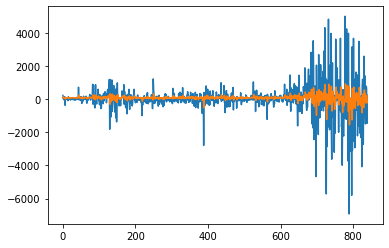

In [54]:
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, label='Predicted')

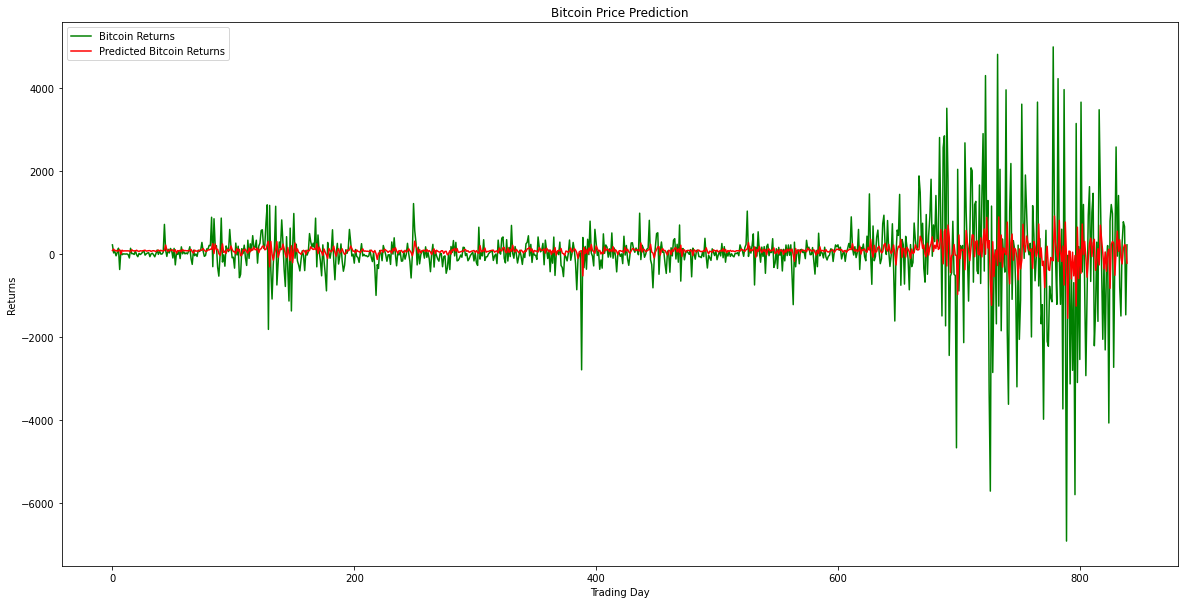

In [55]:
#PLOTTING REAL TESTDATASET VS PREDICTED FOR RETURNS
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'green', label = 'Bitcoin Returns')
plt.plot(inv_yhat, color = 'red', label = 'Predicted Bitcoin Returns')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Trading Day')
plt.ticklabel_format(useOffset=False)
plt.ylabel('Returns')
plt.legend()
plt.show()

In [56]:
return_range = btctweet['Returns'].max() - btctweet['Returns'].min()
return_range

11921.57434

**HOLTS WINTER EXPONENTIAL SMOOTHING**

In [57]:
#TIME SERIES ANALYSIS PREDICTION
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

In [60]:
values = btctweet.values
cols = btctweet.columns.tolist()
cols = cols[-1:] + cols[:-1]
btctweet = btctweet[cols]
btctweet = btctweet[['Returns','bitcoin', 'btc']]
btctweet.head()

,Returns,bitcoin,btc
Date,,,
2014-01-05,71.27,20434,5146
2014-01-06,17.97,16024,5447
2014-01-07,-108.88,27626,5449
2014-01-08,12.82,26925,5185
2014-01-09,15.97,25108,5314


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(btctweet.values)

In [ ]:
n_train_days = 1777
train_data = scaled[:n_train_days, :]
test_data = scaled[n_train_days:, :]

train_data

array([[0.01178563, 0.00618434, 0.00359795],
       [0.01205327, 0.00233005, 0.00430671],
       [0.01032027, 0.01247006, 0.00431142],
       ...,
       [0.05408259, 0.0345094 , 0.08166033],
       [0.05441952, 0.03399637, 0.06767353],
       [0.05508956, 0.04763582, 0.10740406]])

In [ ]:
#not executed
train_data = train_data.astype(np.float)
test_data = test_data.astype(np.float)

In [ ]:
# not executed
train_data = np.log(train_data)
test_data = np.log(test_data)
test_data

array([[ 5.40467839, 11.19663814, 10.92924237],
       [ 3.38404346, 11.25451736, 10.62587795],
       [ 4.13993813, 11.13744625, 10.69704552],
       ...,
       [ 6.50027157, 12.6555036 , 12.01939361],
       [        nan, 13.09789649, 12.175103  ],
       [ 5.40652398, 12.694487  , 12.02631181]])

In [ ]:
 #not executed
from numpy import inf
train_data[train_data == -inf] = 0
test_data[test_data == -inf] = 0

In [ ]:
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
n_day = 1 #adding 1 day lag creating number of observations 
n_features = 2 #Features in the dataset.
n_obs = n_day*n_features

In [ ]:
train_data[:,-3]

array([0.58670776, 0.58223687, 0.5715965 , ..., 0.58178369, 0.58260532,
       0.58437702])

In [ ]:
train_data[:,1:]

array([[0.00618434, 0.00359795],
       [0.00233005, 0.00430671],
       [0.01247006, 0.00431142],
       ...,
       [0.0345094 , 0.08166033],
       [0.03399637, 0.06767353],
       [0.04763582, 0.10740406]])

In [ ]:
train_X, train_y = train_data[:, :n_obs], train_data[:, -n_features]#trainy - only returns , #trainx - first two 
test_X, test_y = test_data[:, :n_obs], test_data[:, -n_features]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_day, n_features))
test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1777, 1, 2) (1777,) (840, 1, 2) (840,)


In [ ]:
train_y

array([ 9.92495546,  9.68184288, 10.22651264, ..., 10.87508053,
       10.86391   , 11.12523151])

In [ ]:
hwmodel = ExponentialSmoothing(train_data[:,-3],seasonal_periods=365, trend='mul', seasonal='mul').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
Forecasting = hwmodel.forecast(steps=840)

In [ ]:
btctweet.dropna(inplace=True)

In [ ]:
Forecasting = Forecasting.reshape(len(Forecasting),1 )

In [ ]:
inv_forecast = concatenate((Forecasting, test_data[:,1:]), axis=1)

In [ ]:
idx = btctweet[1777:]

In [ ]:
pred = scaler.inverse_transform(inv_forecast)

In [ ]:
# example of calculate the mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score
errors = mean_absolute_error(idx['Returns'].values, pred[:,0])
print(errors, " TEST MAE")
print(r2_score(idx['Returns'], pred[:,0]), " Test R2 score")

503.6429660434549  TEST MAE
-0.03313041456009236  Test R2 score


In [ ]:
mse = (mean_squared_error(idx['Returns'], pred[:,0]))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(idx['Returns'], pred[:,0]))
print('Test RMSE: %.3f' % rmse)

Test MSE: 938529.772
Test RMSE: 968.777


In [ ]:
Forecasting = pd.Series(pred[:,0],index=idx.index.to_series())

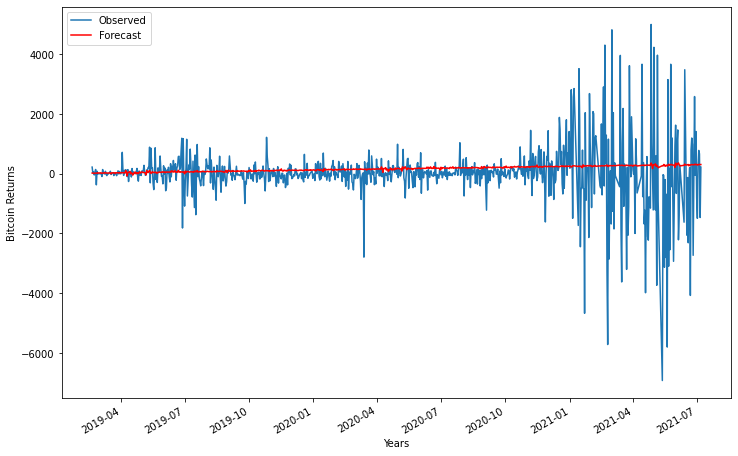

In [ ]:
axis = idx['Returns'].plot(label='Observed', figsize=(12, 8))
Forecasting.plot(ax=axis, label='Forecast',color='r')
axis.set_xlabel('Years')
axis.set_ylabel('Bitcoin Returns')
plt.legend(loc='upper left')
plt.show()

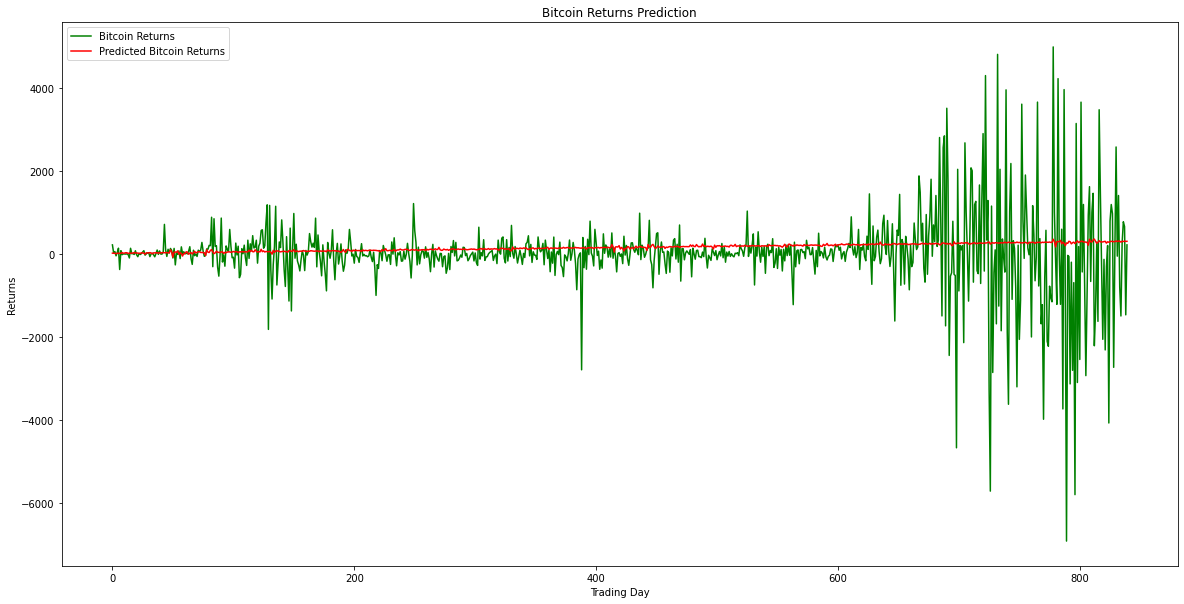

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(idx['Returns'].values, color = 'green', label = 'Bitcoin Returns')
plt.plot(pred[:,0], color = 'red', label = 'Predicted Bitcoin Returns')
plt.title('Bitcoin Returns Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Returns')
plt.legend()
plt.show()

**MULTIVARIATE SARIMAX** 

In [ ]:
model= SARIMAX(train_data[:,-3], 
 exog=train_data[:,1:],
 enforce_invertibility=False, enforce_stationarity=False)

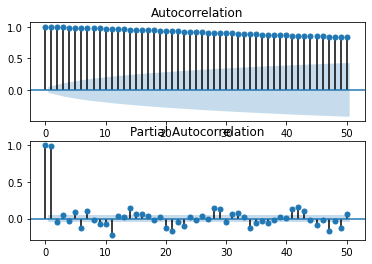

In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train_data[:,-3], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_data[:,-3], lags=50, ax=ax[1])
plt.show()

In [ ]:
results= model.fit()

In [ ]:
Forecasting = results.forecast(steps=840, exog=test_data[:,1:])

In [ ]:
Forecasting = Forecasting.reshape(len(Forecasting),1 )
inv_forecast = concatenate((Forecasting, test_data[:,1:]), axis=1)
idx = btctweet[1777:]
pred = scaler.inverse_transform(inv_forecast)

In [ ]:
pred

array([[  3633.06727817,  72885.        ,  55784.        ],
       [  3701.95856227,  77228.        ,  41187.        ],
       [  3685.66438729,  68696.        ,  44225.        ],
       ...,
       [  3154.142401  , 313484.        , 165942.        ],
       [  3042.05611133, 487915.        , 193901.        ],
       [  3149.97868173, 325946.        , 167094.        ]])

In [ ]:
# example of calculate the mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score
errors = mean_absolute_error(idx['price'].values, pred[:,0])
print(errors, " TEST MAE")
print(r2_score(idx['price'], pred[:,0]), " Test R2 score")

14340.798900277412  TEST MAE
-1.0213771384035621  Test R2 score


In [ ]:
mse = (mean_squared_error(idx['price'], pred[:,0]))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(idx['price'], pred[:,0]))
print('Test RMSE: %.3f' % rmse)

Test MSE: 447572459.124
Test RMSE: 21155.908


In [ ]:
Forecasting = pd.Series(pred[:,0],index=idx.index.to_series())

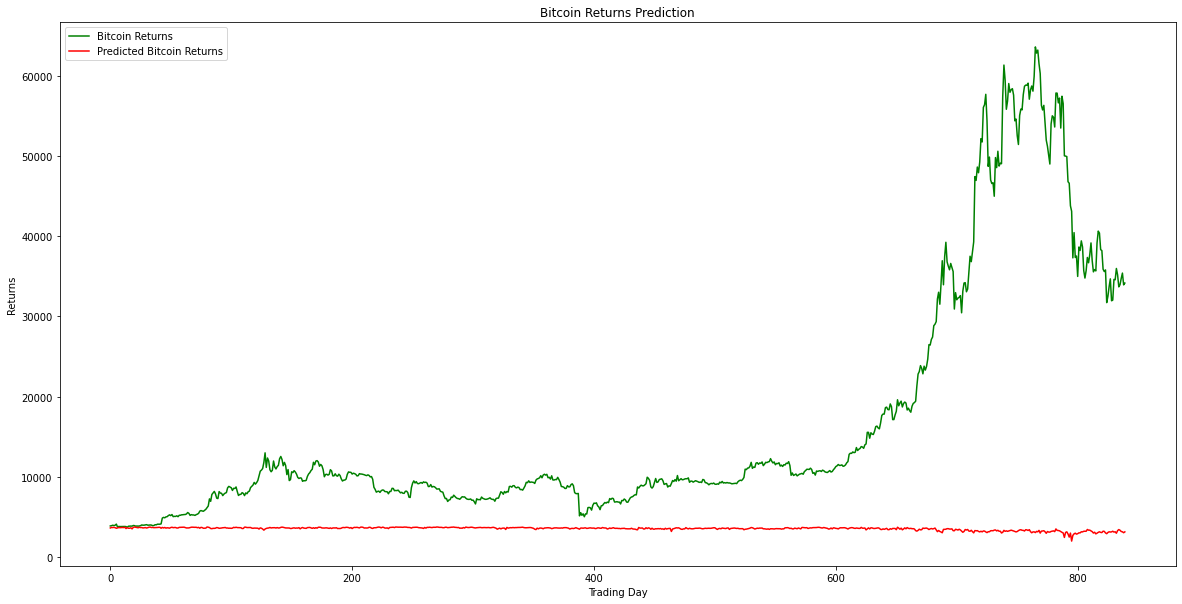

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(idx['price'].values, color = 'green', label = 'Bitcoin Returns')
plt.plot(pred[:,0], color = 'red', label = 'Predicted Bitcoin Returns')
plt.title('Bitcoin Returns Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Returns')
plt.legend()
plt.show()